In [1]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import scipy.stats as stats

from numpy.random import default_rng

%config InlineBackend.figure_format = 'retina'
rng = default_rng(1234)
az.style.use("arviz-darkgrid")

In [2]:
# Produce normally distributed samples
size = 500
true_mu = 13.0
true_sigma = 5.0
samples = rng.normal(true_mu, true_sigma, size)

# Set censoring limits
low = 3.0
high = 16.0


def censor(x, low, high):
    x = copy(x)
    x[x <= low] = low
    x[x >= high] = high
    return x


# Censor samples
censored = censor(samples, low, high)

In [3]:
with pm.Model() as unimputed_censored_model:
    mu = pm.Normal("mu", mu=0.0, sigma=(high - low) / 2.0)
    sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)
    y_latent = pm.Normal.dist(mu=mu, sigma=sigma)
    obs = pm.Censored("obs", y_latent, lower=low, upper=high, observed=censored)
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.9.3 (/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages), Requirement.parse('scipy<=1.7.3,>=0.16')))'.
  entrypoints.init_all()
Sampling: [obs]


# Censored Data Models - when censoring level varies throughout the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import scipy.stats as stats


from datetime import datetime

# Simulate Data

In [5]:
lambd = np.array([0.5,0.5,0.75,1,1.25,1.5,
                  2.5, 3, 3.5, 4, 4, 4, 
                  4, 4, 4.25, 4.25, 4.5, 5, 
                  4.5, 4.25, 4.25, 4, 2, 1.5])

lambd.sum()

73.0

In [6]:
DAYS = 100

minutes = np.arange(60*24*DAYS)
hours = np.tile(np.repeat(np.arange(24), 60), DAYS)
days = minutes//60//24

In [7]:
df = pd.DataFrame({
    "date":pd.date_range("2022-01-01", periods=len(minutes), freq='Min'),
    "day":days,
    "hour":hours,
    "minute":minutes,
    "y":np.random.poisson(lambd[hours]/60)
}).set_index("date")

# How does it look?

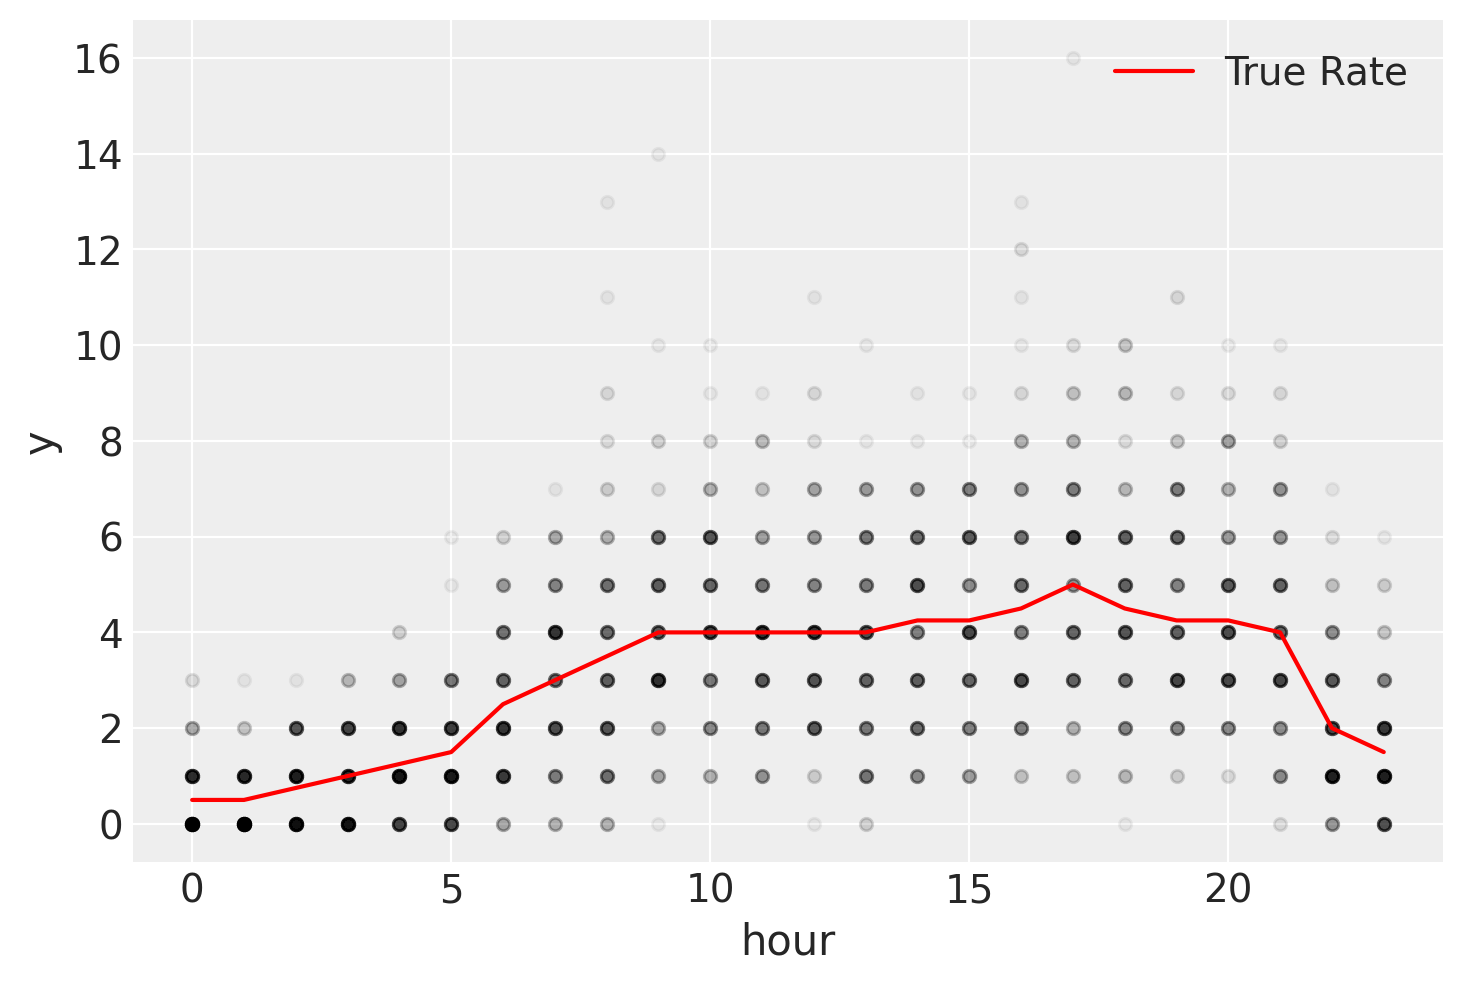

In [8]:
ts = (
    df.groupby(["day", "hour"])
    .y.sum()
    .reset_index(level=0, drop=True)
    .reset_index()
).plot.scatter(x="hour", y="y", alpha=0.05, color="k")
plt.plot(lambd, color="r", label="True Rate")
plt.legend()



# Simulating inventory levels based on latent demand

In [9]:
rng = np.random.default_rng(1234)

stock0 = 300
lognorm_params=(2.5,0.5)
time_to_return = rng.lognormal(*lognorm_params, size=1000000)
df = df.assign(stock0=stock0)

In [10]:
stock = stock0 

invt = [stock0]
y_true = []
returns = {}


for t,day in df.iterrows():
    
    # Simulate rentals - rent as much as inventory supports
    latent_demand = day.y
    rentals = latent_demand if latent_demand <= stock else stock
    stock -= rentals
    y_true.append(rentals)
    
    # simulate return times
    if rentals > 0:
        return_time_days = np.random.lognormal(*lognorm_params, size=rentals) + day.day
        return_times = np.ceil(return_time_days*60*24).astype(int)
        for val in return_times:
            if returns.get(val) is not None:
                returns[val] += 1
            else:
                returns[val] = 1
    
    # Get stock for next time period ready
    if returns.get(day.minute) is not None:
        stock += returns.get(day.minute)
        
    invt.append(stock)
    

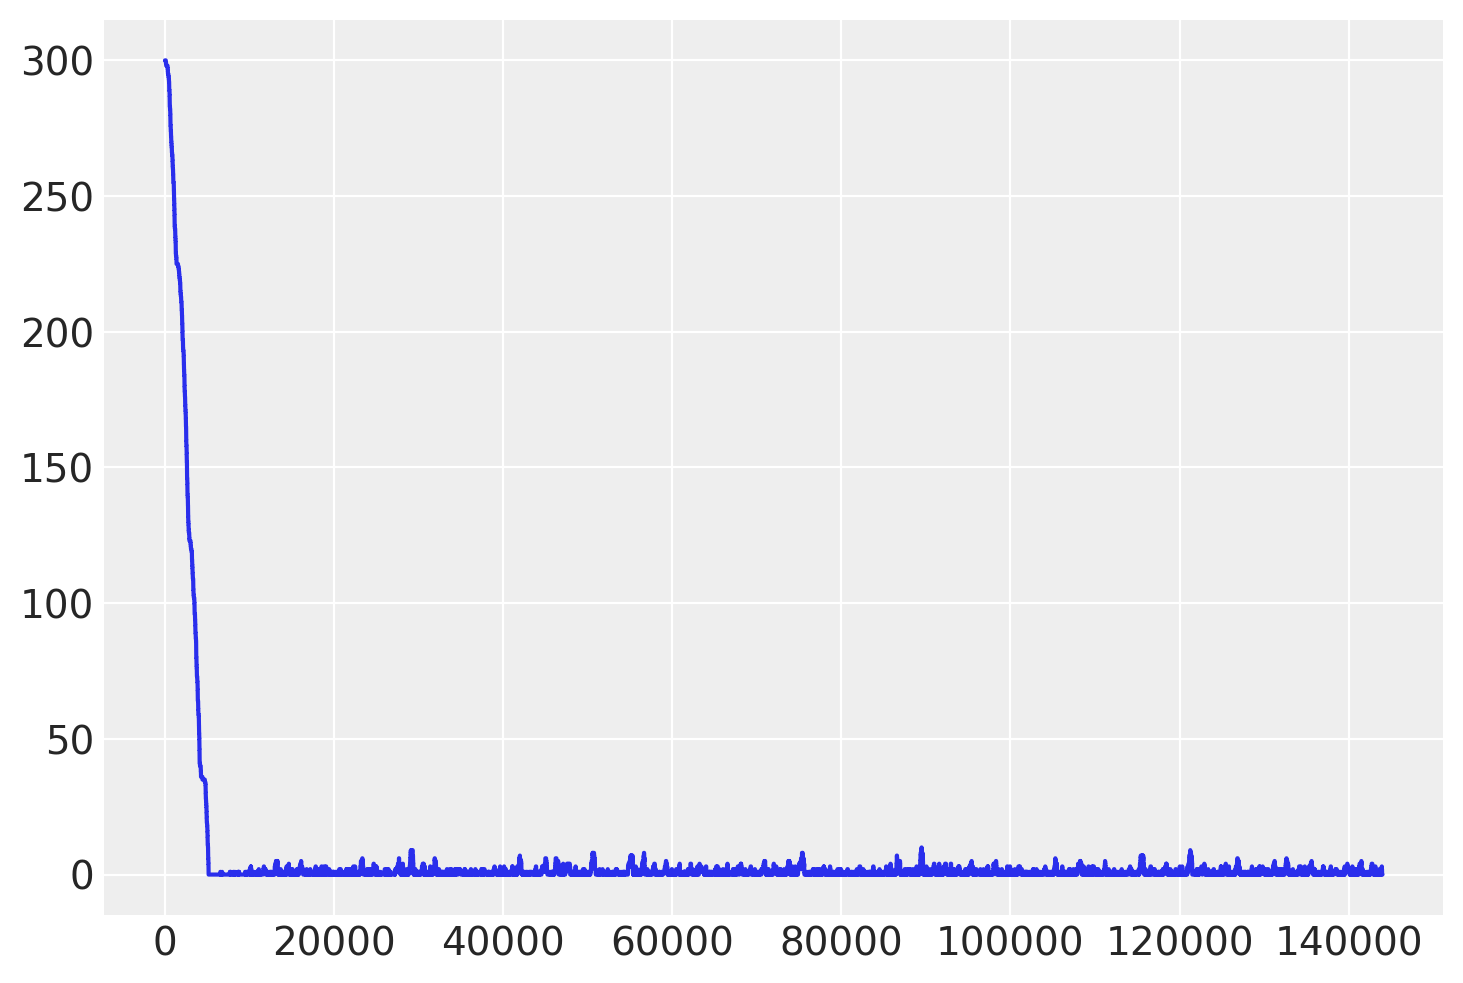

In [11]:
plt.plot( invt )

In [12]:
data = (
    df.assign(stock=invt[:-1])
    .assign(rentals=y_true)
)

In [13]:
(data.stock < data.y).sum()

4947

Text(0.5, 1.0, 'In Stock Rate')

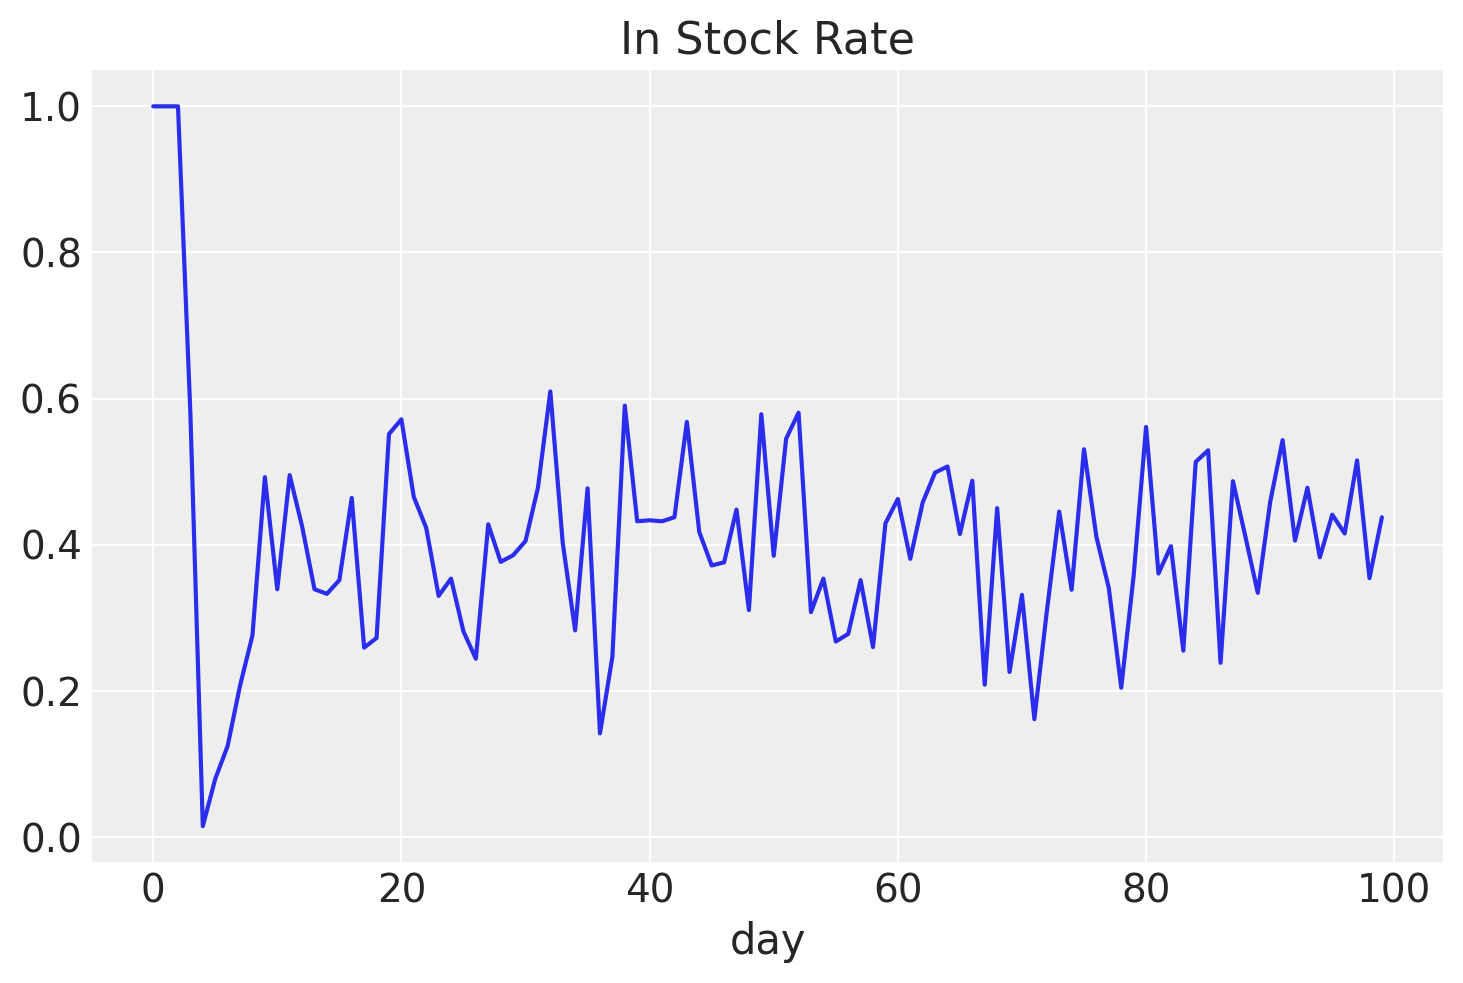

In [14]:
(data.groupby("day").apply(lambda x: (x.stock>0).mean())).plot()
plt.title("In Stock Rate")

In [15]:
data.head(10)

,day,hour,minute,y,stock0,stock,rentals
date,,,,,,,
2022-01-01 00:00:00,0,0,0,0,300,300,0
2022-01-01 00:01:00,0,0,1,0,300,300,0
2022-01-01 00:02:00,0,0,2,0,300,300,0
2022-01-01 00:03:00,0,0,3,0,300,300,0
2022-01-01 00:04:00,0,0,4,0,300,300,0
2022-01-01 00:05:00,0,0,5,0,300,300,0
2022-01-01 00:06:00,0,0,6,0,300,300,0
2022-01-01 00:07:00,0,0,7,0,300,300,0
2022-01-01 00:08:00,0,0,8,0,300,300,0


In [16]:
data.tail()

,day,hour,minute,y,stock0,stock,rentals
date,,,,,,,
2022-04-10 23:55:00,99,23,143995,0,300,0,0
2022-04-10 23:56:00,99,23,143996,0,300,0,0
2022-04-10 23:57:00,99,23,143997,0,300,0,0
2022-04-10 23:58:00,99,23,143998,0,300,0,0
2022-04-10 23:59:00,99,23,143999,0,300,0,0


<AxesSubplot:ylabel='Count'>

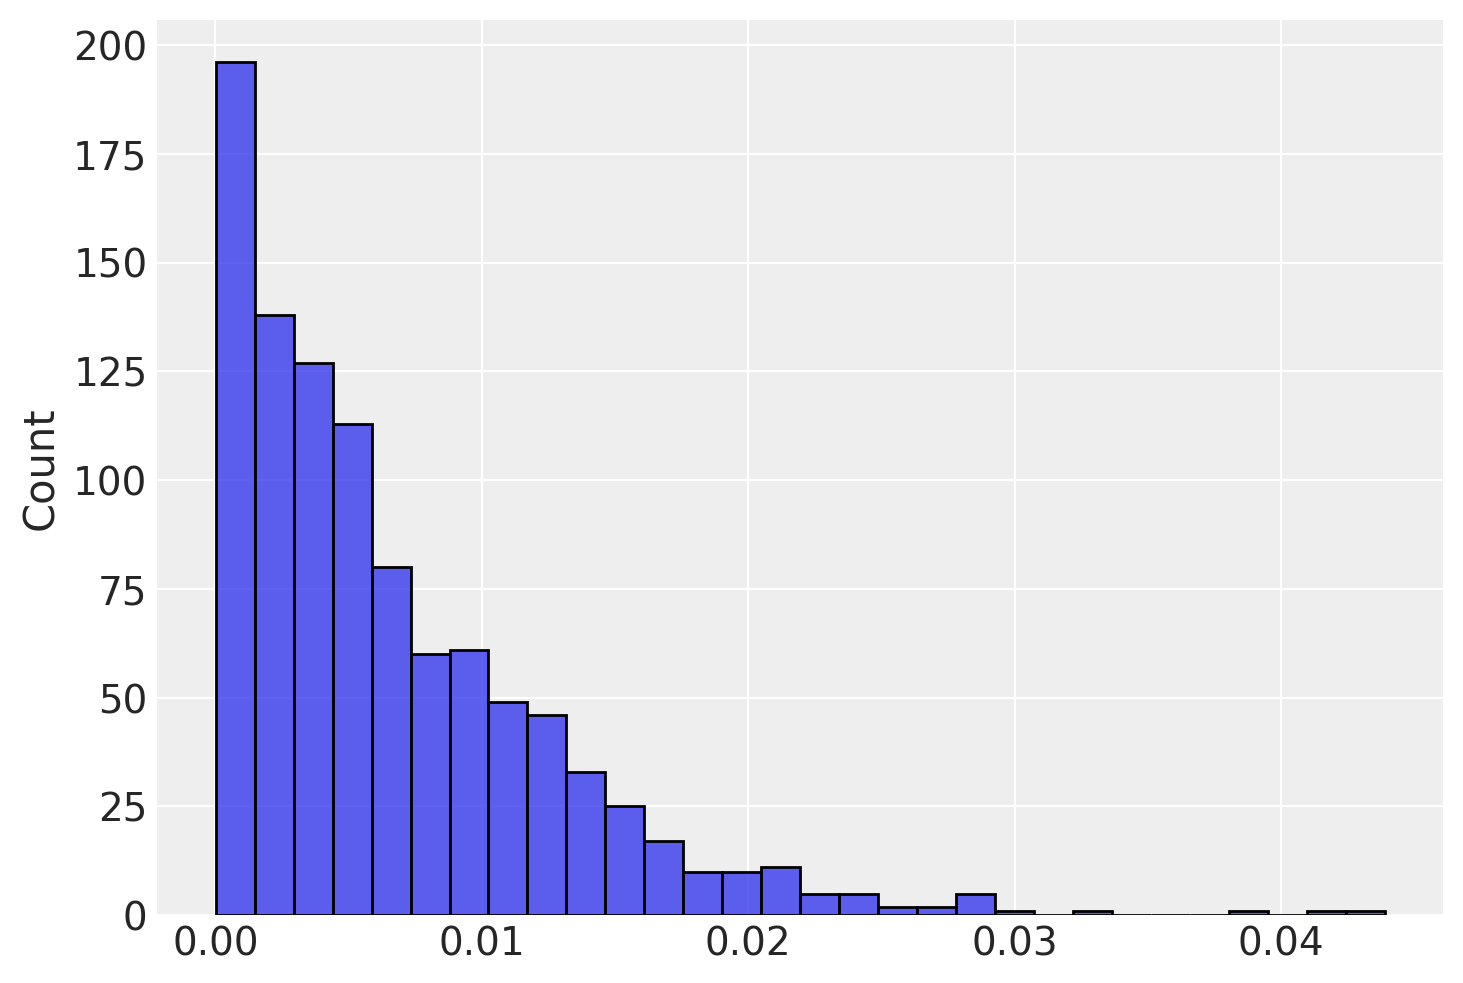

In [17]:
sns.histplot( pm.draw(pm.Exponential.dist(2.5*60), 1000) )

In [18]:
d = data #.head(1000)

In [42]:
coords = {"hour":np.arange(24)}
h_ = d.hour.values
with pm.Model(coords=coords) as m1:
    
    lambd = pm.Gamma("lambd", 1, 25, dims="hour")
    y_latent = pm.Poisson.dist(lambd[h_])
    
#     obs=pm.Poisson("obs", lambd[h_], observed=)
    obs = pm.Censored(
        "obs", 
        y_latent,
        lower=None,
        upper=d.stock.values,
        observed=d.rentals.values
    )
    
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 451 seconds.


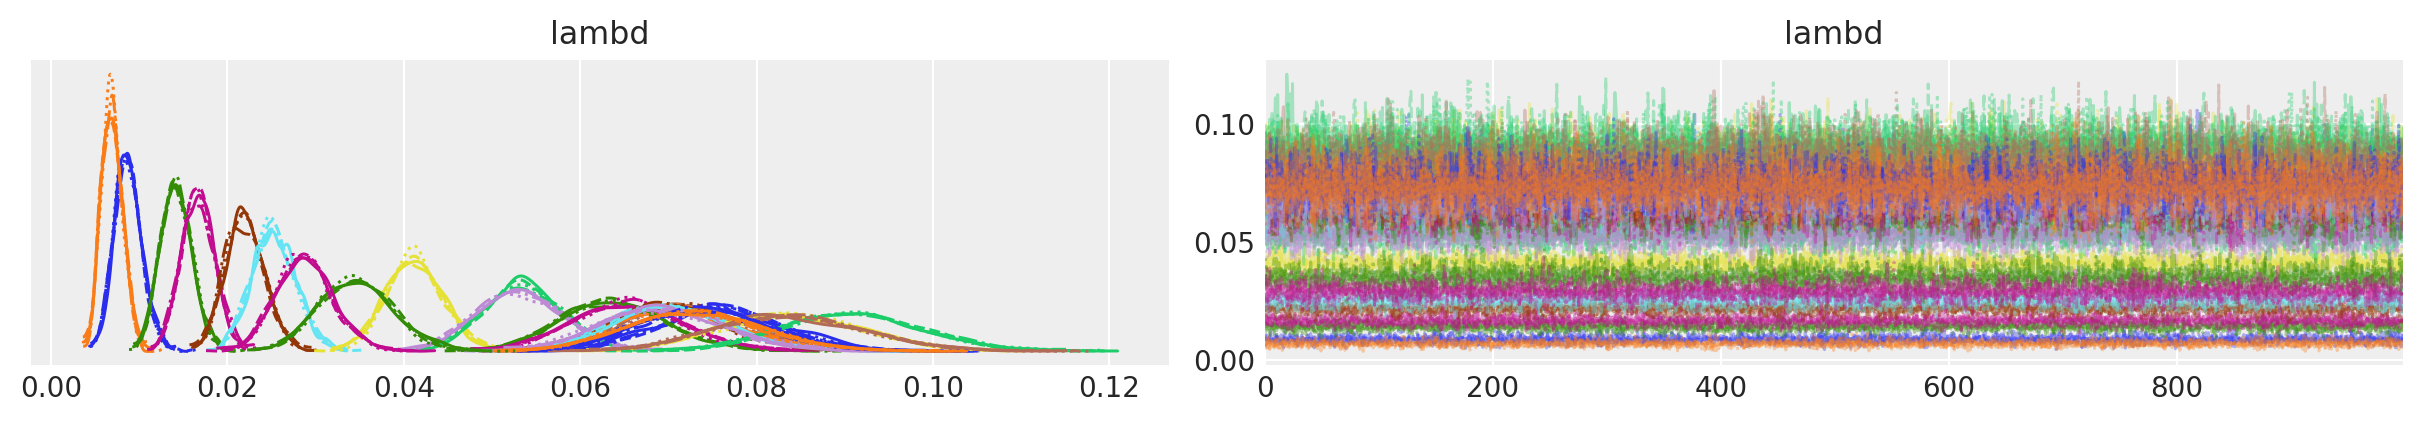

In [43]:
pm.plot_trace(idata, var_names=["lambd"]);

In [44]:
summary = pd.concat((
    data.resample("H").agg(["mean", "sum"])["stock"],
    data.resample("H").sum()["rentals"],
),axis=1)


(
    summary.loc[lambda d: d.rentals >= d["mean"]]
    [["mean","rentals"]]\
    .assign(possible=lambda d: 
            d.apply(lambda x: np.random.poisson(x["mean"], size=100000).max(),axis=1))
    .loc[lambda d: d.possible < d.rentals]
    
)

,mean,rentals,possible
date,,,


# Trying to aggregate

In [45]:
d = data.resample("H").agg({"stock":"mean", "rentals":"sum", "hour":"first"})

coords = {"hour":np.arange(24)}
h_ = d.hour.values

with pm.Model(coords=coords) as m_hourly:
    
    lambd = pm.Gamma("lambd", 1, 25/60, dims="hour")
    y_latent = pm.Poisson.dist(lambd[h_])

    obs = pm.Censored(
        "obs", 
        y_latent,
        lower=None,
        upper=d[["stock", "rentals"]].max(1),
        observed=d.rentals.values
    )
    
    idata_hourly = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

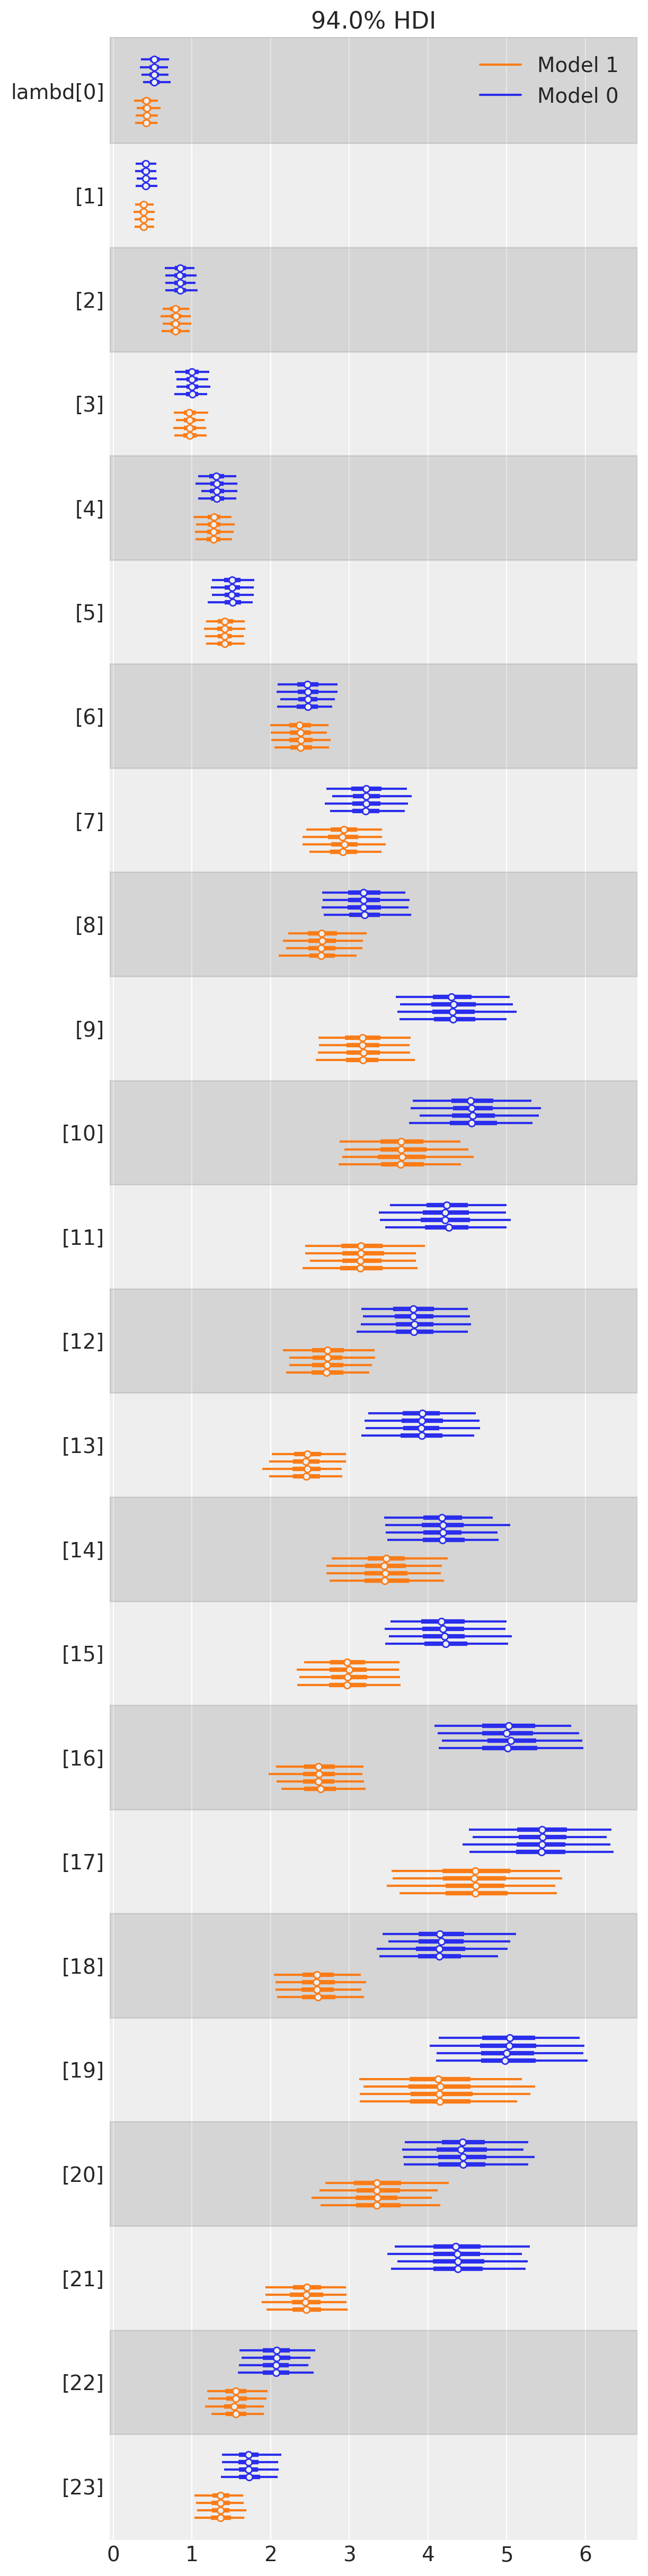

In [46]:
pm.plot_forest(
    [idata.posterior*60, idata_hourly],
    var_names=["lambd"])

In [47]:
d = data.resample("D").agg({"stock":"mean", "rentals":"sum"})

with pm.Model() as m_daily:
    
    lambd = pm.Gamma("lambd", 2, 0.025)
    y_latent = pm.Poisson.dist(lambd)

    obs = pm.Censored(
        "obs", 
        y_latent,
        lower=None,
        upper=d[["stock", "rentals"]].max(1),
        observed=d.rentals.values
    )
    
    idata_daily = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


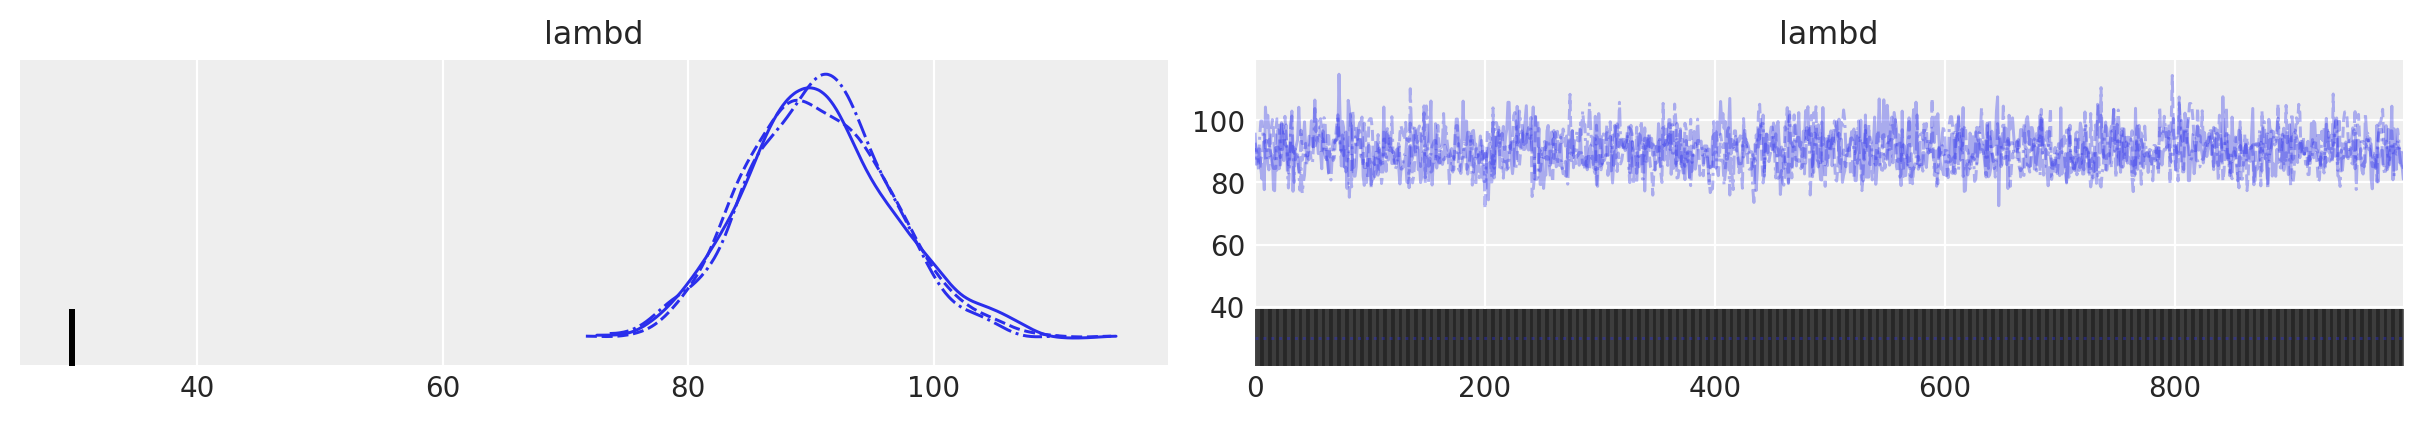

In [48]:
pm.plot_trace(idata_daily);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

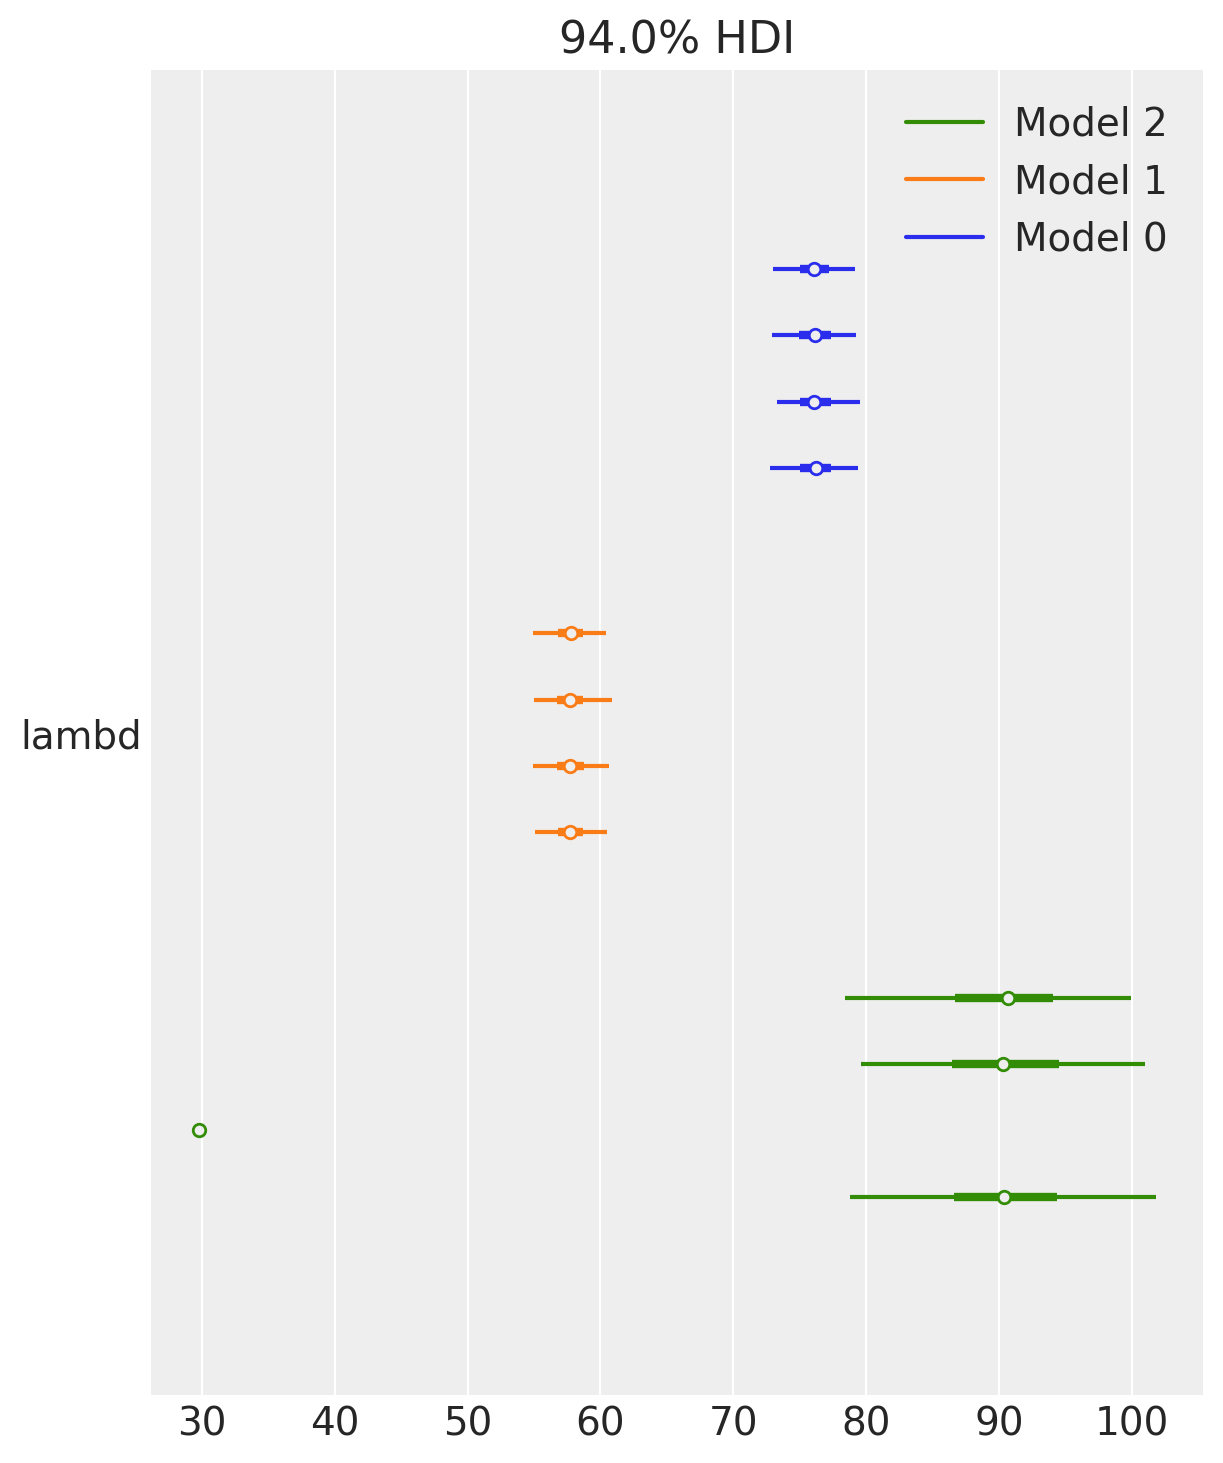

In [49]:
pm.plot_forest(
    [(idata.posterior*60).sum("hour"), 
     idata_hourly.posterior.sum("hour"),
     idata_daily.posterior
    ],
    var_names=["lambd"]
)

# Using the max

In [50]:
d = (
    data.
    assign(
        returns = lambda d: 
            np.clip(d.stock - d.stock.shift(1, fill_value=0),0,np.inf)
          )
    .resample("D")
    .agg({"returns":"sum", "rentals":"sum", "stock":"first"})
    .assign(stock=lambda d: d.stock+d.returns)
)

with pm.Model() as m_daily_max:
    
    lambd = pm.Gamma("lambd", 2, 0.025)
    y_latent = pm.Poisson.dist(lambd)

    obs = pm.Censored(
        "obs", 
        y_latent,
        lower=None,
        upper=d[["stock", "rentals"]].max(1),
        observed=d.rentals.values
    )
    
    idata_daily_max = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

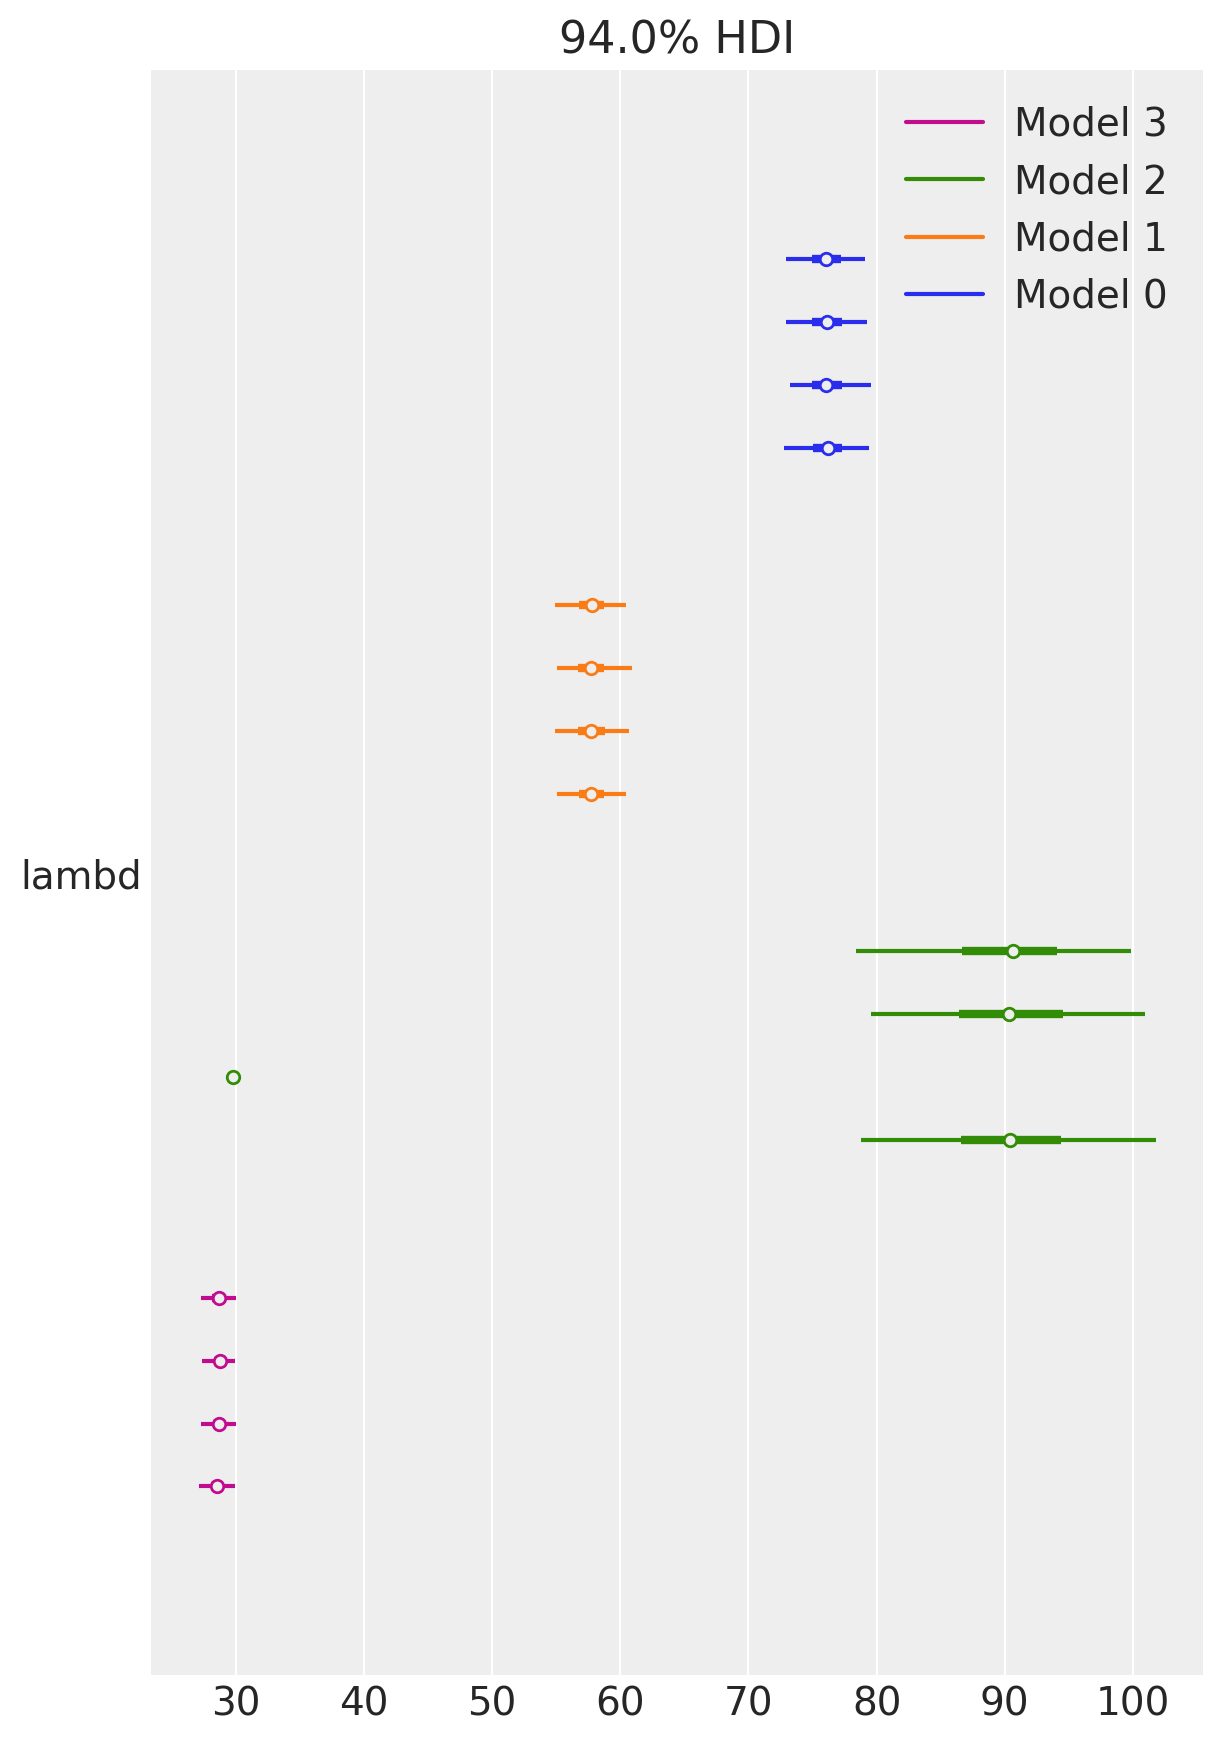

In [51]:
pm.plot_forest(
    [(idata.posterior*60).sum("hour"), 
     idata_hourly.posterior.sum("hour"),
     idata_daily.posterior,
     idata_daily_max.posterior,
    ],
    var_names=["lambd"]
)

# ADVI

In [53]:
with m1:
    
    approx = pm.fit()


Finished [100%]: Average Loss = 9,462.8


In [54]:
idata_advi = approx.sample(draws=4000)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

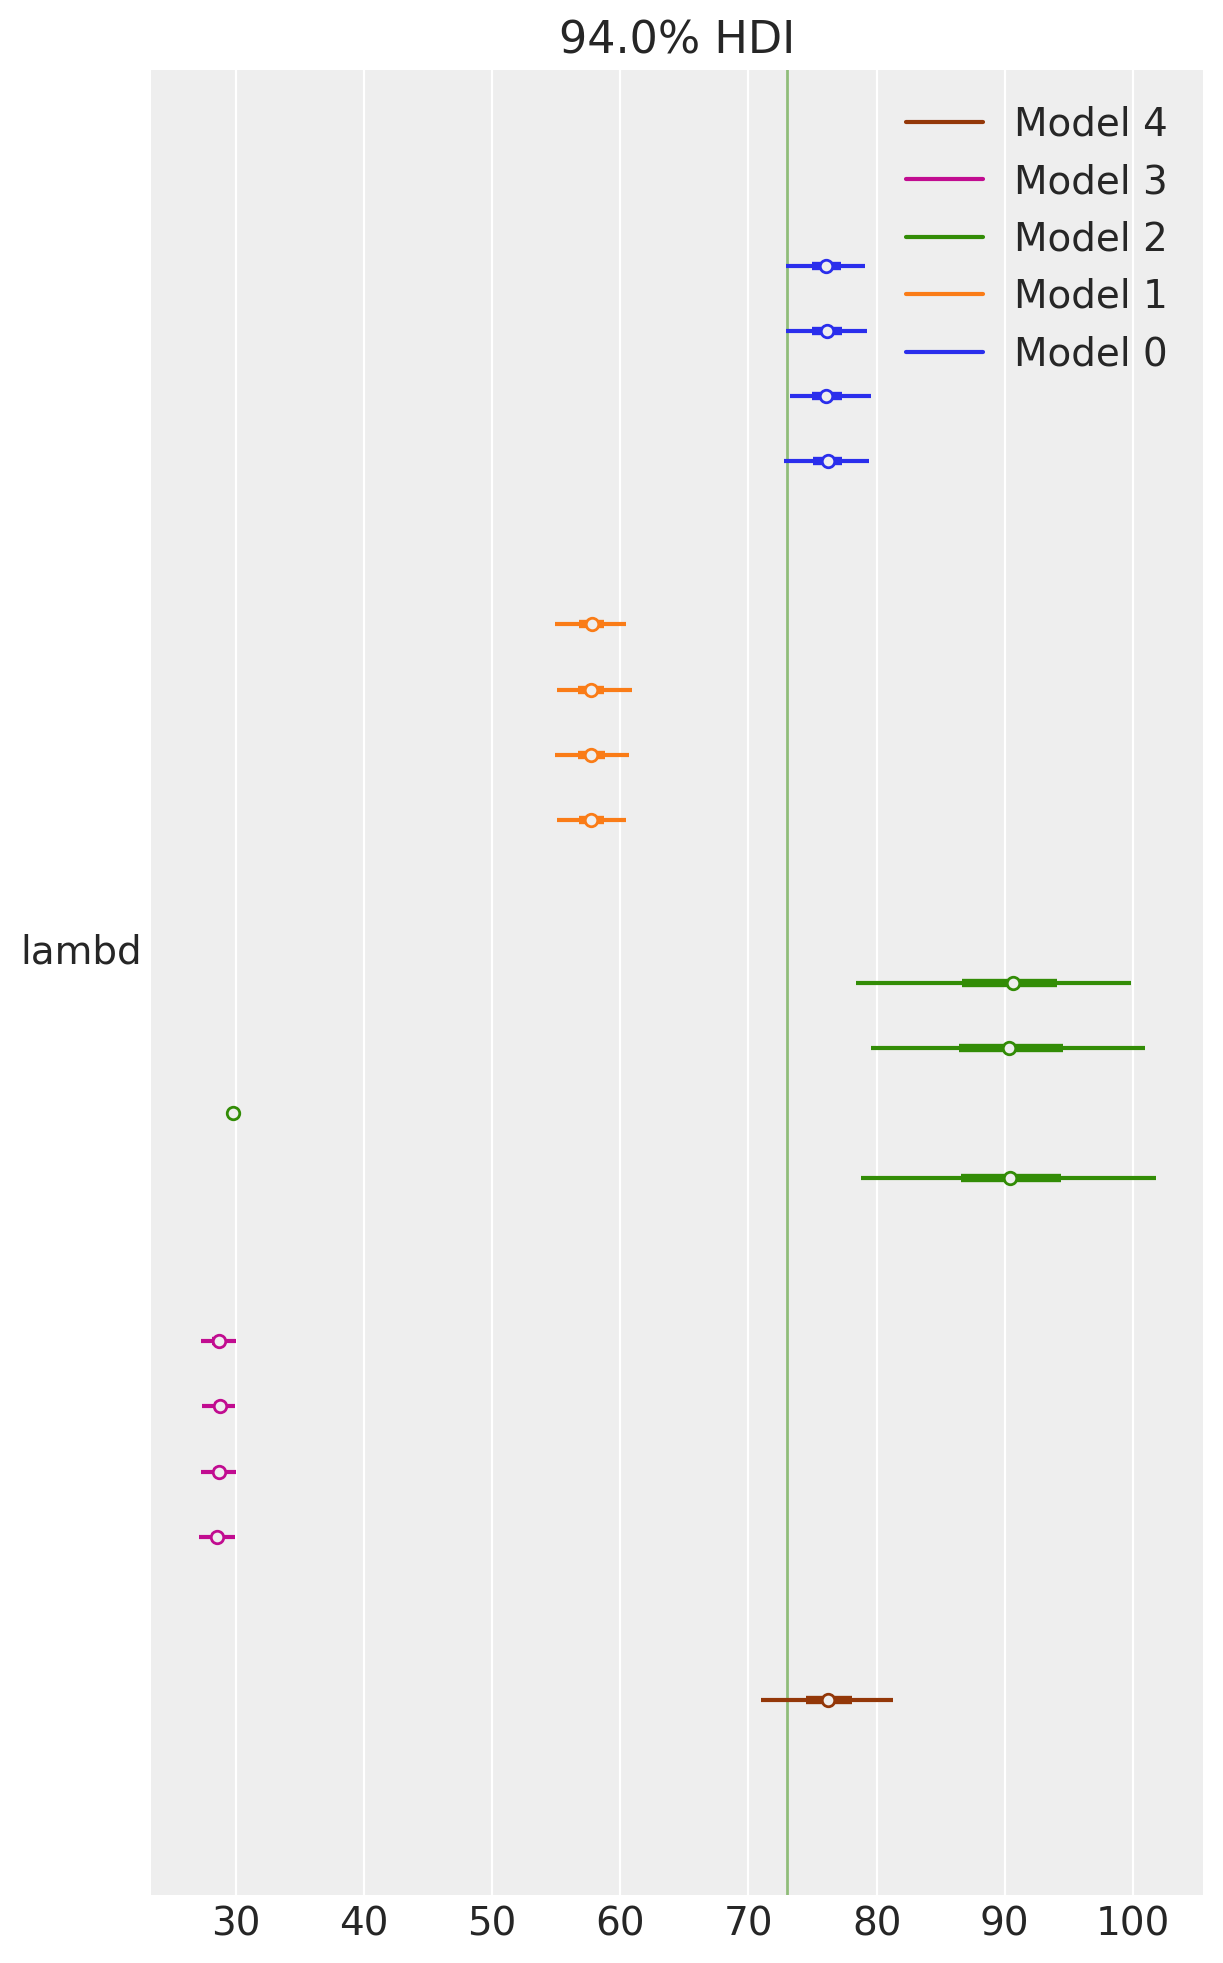

In [57]:
pm.plot_forest(
    [(idata.posterior*60).sum("hour"), 
     idata_hourly.posterior.sum("hour"),
     idata_daily.posterior,
     idata_daily_max.posterior,
     (idata_advi.posterior*60).sum("hour")
    ],
    var_names=["lambd"],
    rope=73+np.array([-0.01,0.01]),
)

In [80]:
weights = data.groupby("hour").rentals.mean().rename("w")
weights/=weights.sum()

In [85]:
d = (
    data
    .resample("H")
    .agg({"stock":"mean", "hour":"first", "rentals":"sum"})
    .merge(weights,how="left", left_on="hour", right_index=True)
    .assign(stock = lambda d: d.stock*d.w)
    .resample("D")
    .sum()
    .assign(stock=lambda d: np.ceil(d.stock))
    [["stock", "rentals"]]
)

In [86]:
with pm.Model() as m_daily_weighted:
    
    lambd = pm.Gamma("lambd", 2, 0.025)
    y_latent = pm.Poisson.dist(lambd)

    obs = pm.Censored(
        "obs", 
        y_latent,
        lower=None,
        upper=d[["stock", "rentals"]].max(1),
        observed=d.rentals.values
    )
    
    idata_daily_weighted = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

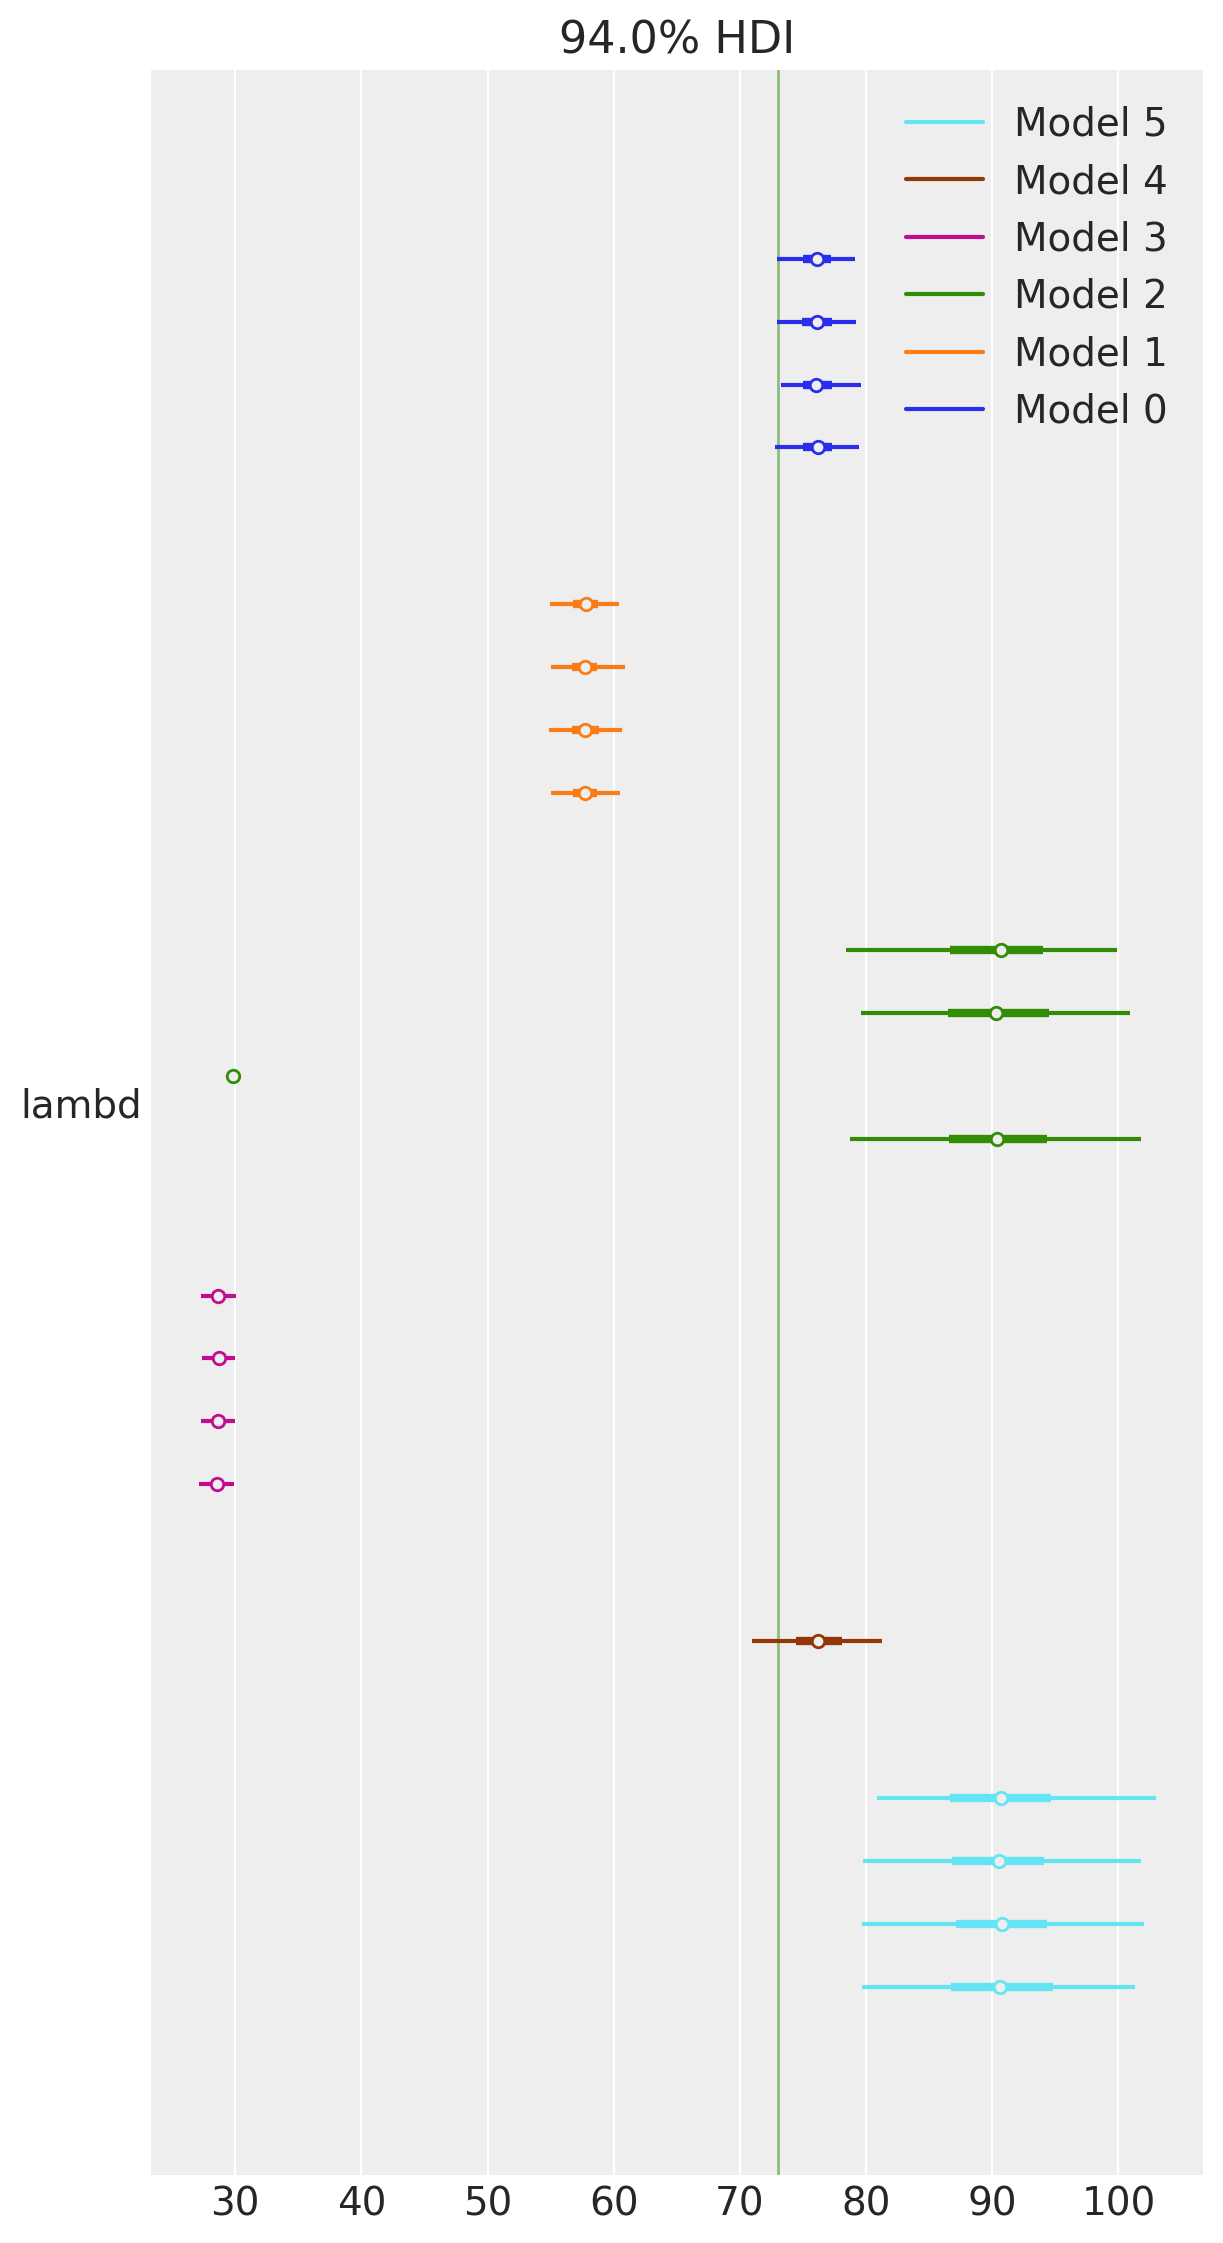

In [87]:
pm.plot_forest(
    [(idata.posterior*60).sum("hour"), 
     idata_hourly.posterior.sum("hour"),
     idata_daily.posterior,
     idata_daily_max.posterior,
     (idata_advi.posterior*60).sum("hour"),
     idata_daily_weighted.posterior,
    ],
    var_names=["lambd"],
    rope=73+np.array([-0.01,0.01]),
)